In [11]:
import os
os.environ["OMP_NUM_THREADS"] = "32"
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS
import matplotlib.pyplot as plt
import matplotlib.cm as mpl
import seaborn as sns
import statsmodels.api as sm
from multipy.fdr import qvalue
from multipy.fdr import lsu
import random as rn

import dill

from rpy2.robjects.packages import importr, data

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Introduction

We ouline a series of simulations to illustrate what aspects of the community structure in correlation matrices are captured by different clustering methods.

We will folow the strategy of creading networks with known community structure, adding known weights to the edges, and creating correlations matrices from these known networks. 
We then attempt to recover the original community structure from this correlation matrix.

## Random networks
 
We start with a random network with 50 vertices, generated by a Erdős–Rényi model.

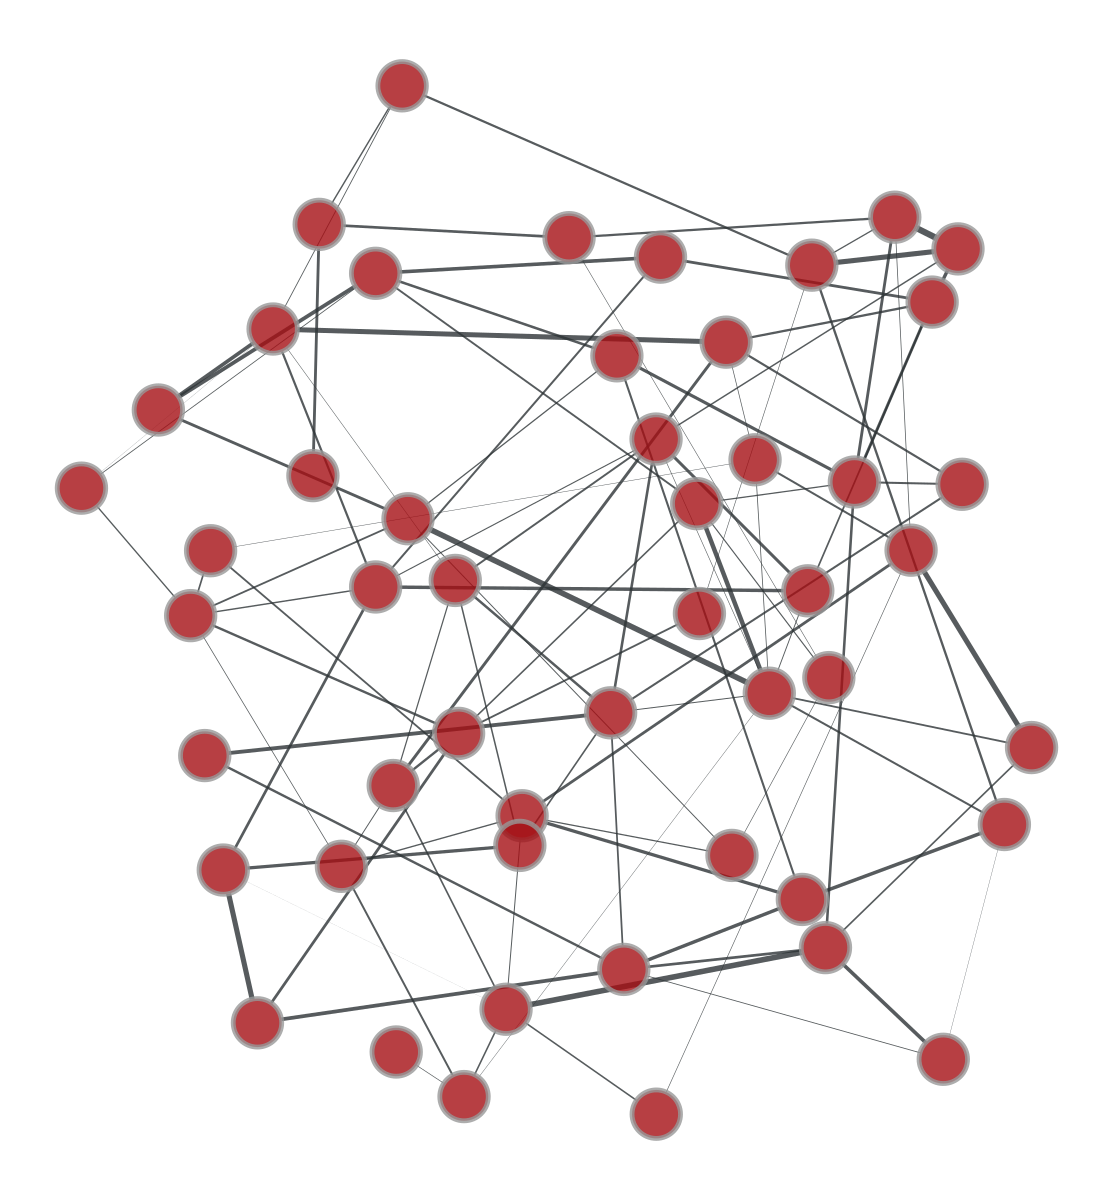

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7efd21ed5a10, at 0x7efd23359290>

In [96]:
np.random.seed(1)
seed_rng(1)
g, pos = triangulation(np.random.random((50,2)))
N = len(g.get_edges())
g.ep.weight = g.new_edge_property("double", np.random.normal(0.6, 1, N))
g.ep.correlations = g.new_edge_property("double", np.tanh(g.ep.weight.a/2))
ret = random_rewire(g, "erdos")
pos = arf_layout(g)
graph_draw(g, pos=pos, edge_pen_width = g.ep.weight)

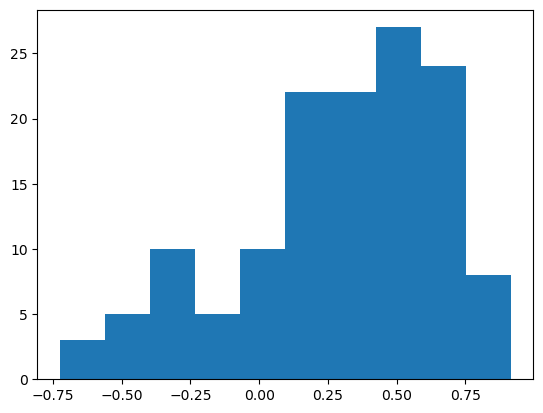

In [97]:
plt.hist(g.ep.correlations.a)
plt.show() 

/tmp/ipykernel_537384/796553485.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  simulated_obs = np.random.multivariate_normal(np.zeros(50), dA, 1000)


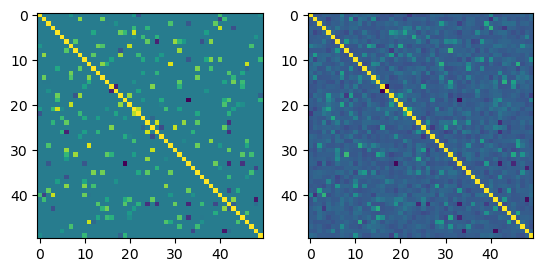

In [98]:
A = adjacency(g, weight=g.ep.correlations)
dA = A.todense()
for i in range(50):
    dA[i,i] = 1
simulated_obs = np.random.multivariate_normal(np.zeros(50), dA, 1000)
import scipy.stats as stats

correlation_matrix = stats.spearmanr(simulated_obs, axis=0).correlation

plt.subplot(1, 2, 1)
plt.imshow(dA, interpolation='nearest')
plt.subplot(1, 2, 2)
plt.imshow(correlation_matrix, interpolation='nearest')
plt.show()

In [4]:
def filterByFDR(g, level, keepOnlyMain):
    # Filtering edges
    pvals = np.array(g.edge_properties["pvalue"].a)

    fdr_ep = g.new_ep("bool", True)
    fdr_ep.a = lsu(pvals, q=level)

    tv = GraphView(g, efilt=fdr_ep)

    # Keeping largest component
    if keepOnlyMain:
        comp, hist = label_components(tv)
        main_component = tv.new_vp("bool", (comp.a == np.where(hist == max(hist))[0][0]))
        tv.vertex_properties["main_component"] = main_component
        tv.set_vertex_filter(main_component)
    return tv

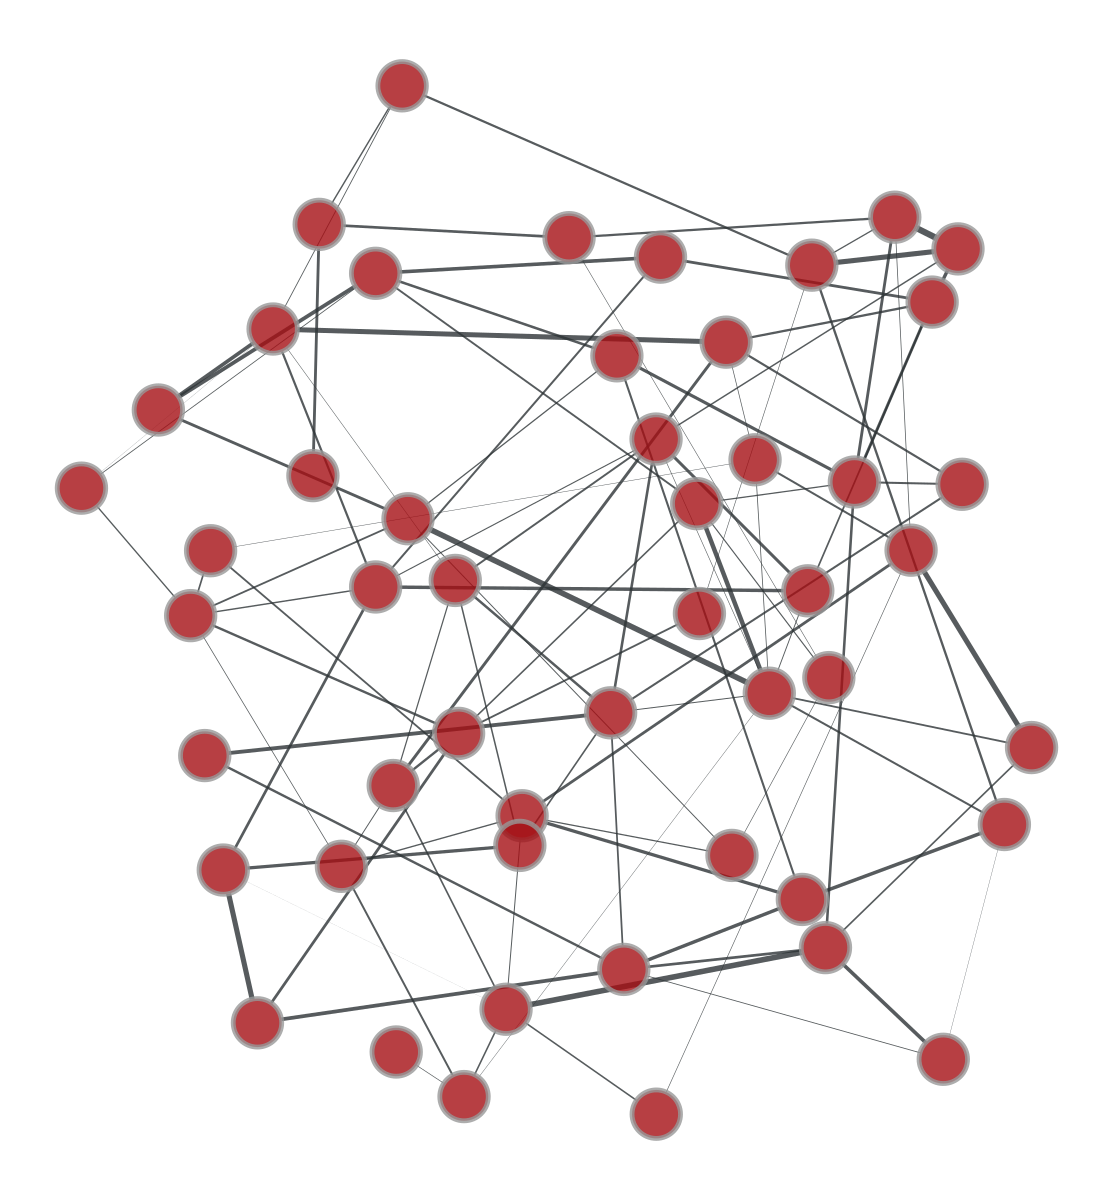

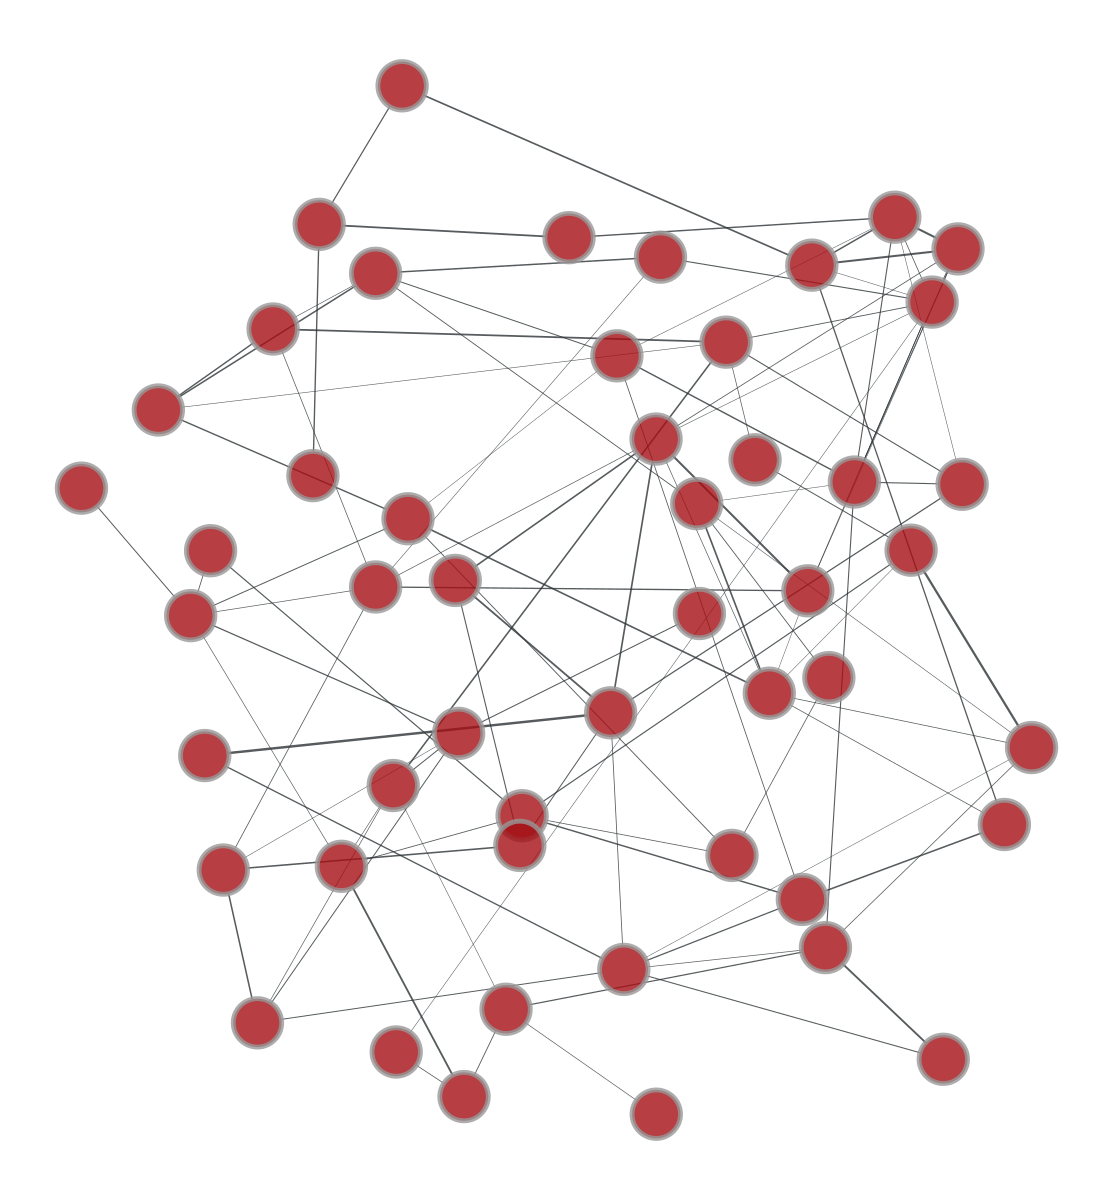

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7efd3042fb50, at 0x7efd23713f90>

In [100]:
gene_expr = simulated_obs

g_obs = Graph(directed=False)
g_obs.add_vertex(n = 50)

spearman = g_obs.new_ep("double", 0)
pval = g_obs.new_ep("double", 0)

for i in range(50):
    for j in range(i):
        spearman_r = sp.stats.spearmanr(gene_expr[:,i], gene_expr[:,j])
        g_obs.add_edge(i, j)
        e = g_obs.edge(i, j)
        pval[e] = spearman_r[1]
        spearman[e] = spearman_r[0]

g_obs.edge_properties["pvalue"] = pval
g_obs.edge_properties["spearman"] = spearman
g_obs.ep.weight = g_obs.new_edge_property("double", 2*np.arctanh(spearman.a))


tv = filterByFDR(g_obs, 1e-3, True)
g_trim = Graph(tv, prune = False)

graph_draw(g, pos=pos, edge_pen_width = g.ep.weight)
graph_draw(g_trim, pos=pos, edge_pen_width = g_trim.ep.weight)

In [101]:
state = minimize_nested_blockmodel_dl(g_trim, state_args=dict(recs=[g_trim.ep.weight],
                                                              rec_types=["real-normal"], deg_corr=True))
mcmc_equilibrate(state, wait=10, nbreaks=2, mcmc_args=dict(niter=10))

KeyboardInterrupt: 

In [ ]:
# collect nested partitions
bs = []

def collect_partitions(s):
   global bs
   bs.append(s.get_bs())

# Now we collect the marginals for exactly 100,000 sweeps
mcmc_equilibrate(state, force_niter=1000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, nested=True, converge=True)
pv = pmode.get_marginal(g_trim)

# Get consensus estimate
bs = pmode.get_max_nested()

state = state.copy(bs=bs)


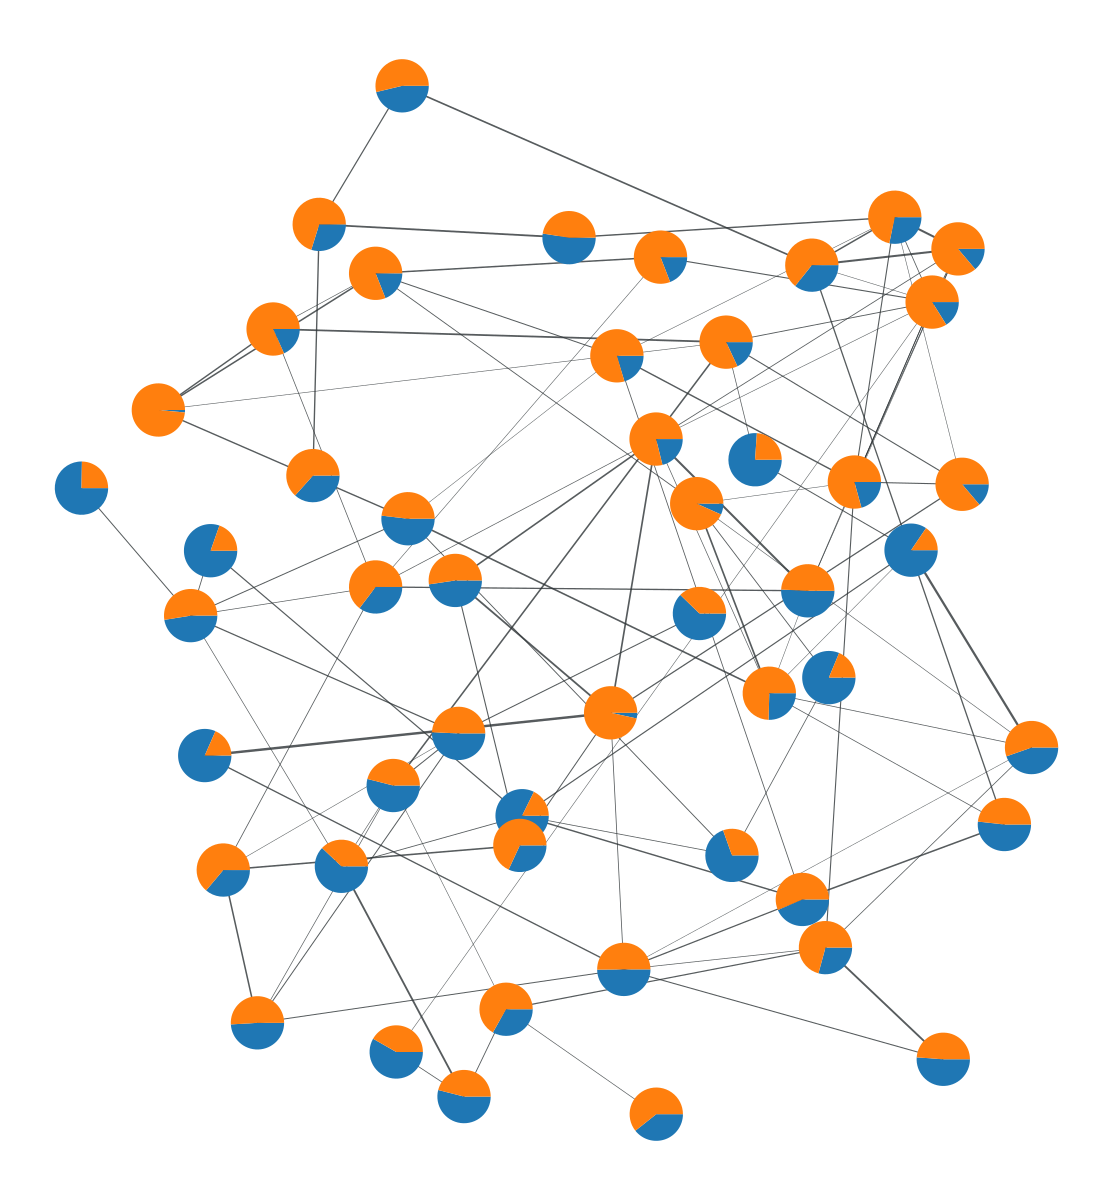

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7efd302fe3d0, at 0x7efd302bfcd0>

In [ ]:

# We can visualize the marginals as pie charts on the nodes:
graph_draw(g_trim, pos=pos, edge_pen_width = g_trim.ep.weight, vertex_shape="pie", vertex_pie_fractions=pv)

# Modular network

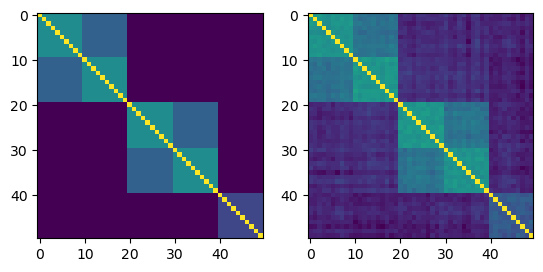

In [2]:
modular_matrix = pd.read_csv("modular_matrix.csv", index_col=0)

simulated_obs = np.random.multivariate_normal(np.zeros(50), modular_matrix, 1000)
import scipy.stats as stats

correlation_matrix = stats.spearmanr(simulated_obs, axis=0).correlation

plt.subplot(1, 2, 1)
plt.imshow(modular_matrix, interpolation='nearest')
plt.subplot(1, 2, 2)
plt.imshow(correlation_matrix, interpolation='nearest')
plt.show()

In [7]:
np.random.seed(1)
seed_rng(1)

gene_expr = simulated_obs

g_mod = Graph(directed=False)
g_mod.add_vertex(n = 50)

spearman = g_mod.new_ep("double", 0)
pval = g_mod.new_ep("double", 0)

for i in range(50):
    for j in range(i):
        spearman_r = sp.stats.spearmanr(gene_expr[:,i], gene_expr[:,j])
        g_mod.add_edge(i, j)
        e = g_mod.edge(i, j)
        pval[e] = spearman_r[1]
        spearman[e] = spearman_r[0]

g_mod.edge_properties["pvalue"] = pval
g_mod.edge_properties["spearman"] = spearman
g_mod.ep.weight = g_mod.new_edge_property("double", 2*np.arctanh(spearman.a))
community = [1] * 10 + [2] * 10 + [3] * 10 + [4] * 10 + [5] * 10
g_mod.vp.community = g_mod.new_vertex_property("int", community)
upper = [6] * 20 + [7] * 20 + [8] * 10
g_mod.vp.upper = g_mod.new_vertex_property("int", upper)

tv = filterByFDR(g_mod, 1e-3, False)
g_mod_trim = Graph(tv, prune = False)
pos = arf_layout(g_mod_trim)


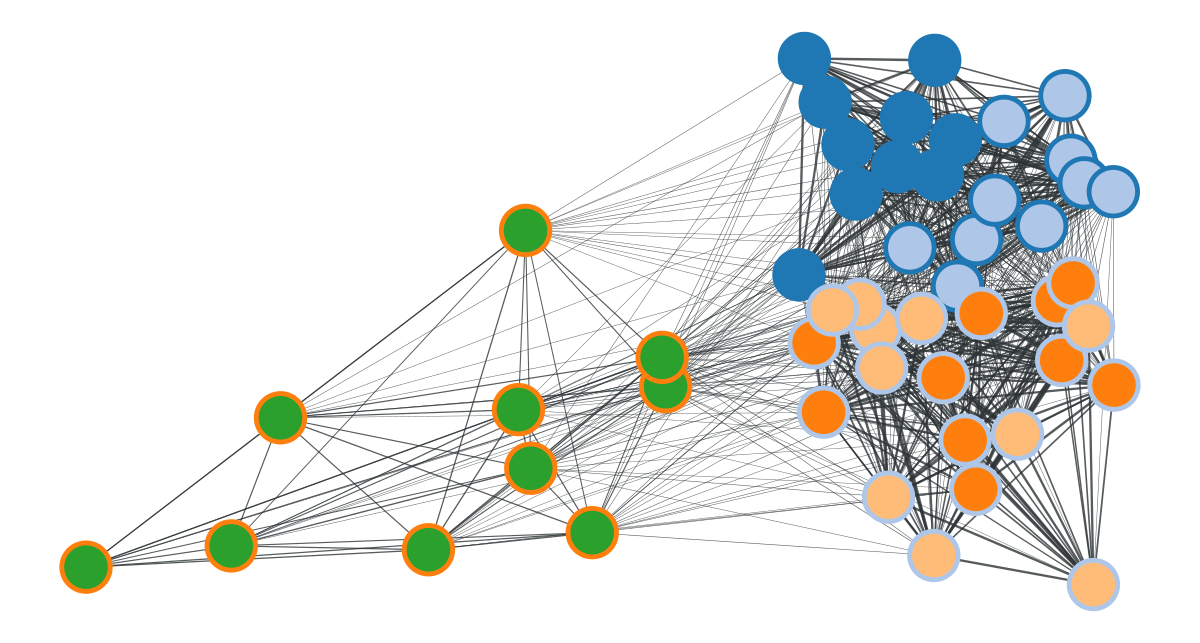

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe0167e8090, at 0x7fe016964150>

In [8]:

graph_draw(g_mod_trim, pos = pos, edge_pen_width = g_mod_trim.ep.weight, vertex_color=g_mod_trim.vp.upper , vertex_fill_color=g_mod_trim.vp.community)

In [9]:
state = minimize_nested_blockmodel_dl(g_mod_trim, state_args=dict(recs=[g_mod_trim.ep.weight],
                                                                  rec_types=["real-normal"]))
mcmc_equilibrate(state, wait=100, nbreaks=2, mcmc_args=dict(niter=10))

(-61.75936662339276, 1193519, 523823)

In [19]:
# collect nested partitions
bs = []

def collect_partitions(s):
   global bs
   bs.append(s.get_bs())

# Now we collect the marginals for exactly 100,000 sweeps
mcmc_equilibrate(state, force_niter=1000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

(-67.18682314527555, 3056484, 913288)

In [20]:
# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, nested=True, converge=True)
pv = pmode.get_marginal(g_mod_trim)

# Get consensus estimate
bst = pmode.get_max_nested()
state = state.copy(bs=bst[0:3])

In [27]:

state = state.copy(bs=bst[0:3])
bst

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4], dtype=int32),
 array([0, 0, 1, 1, 0], dtype=int32),
 array([0, 1, 2, 0, 0], dtype=int32),
 array([0, 2, 1], dtype=int32)]

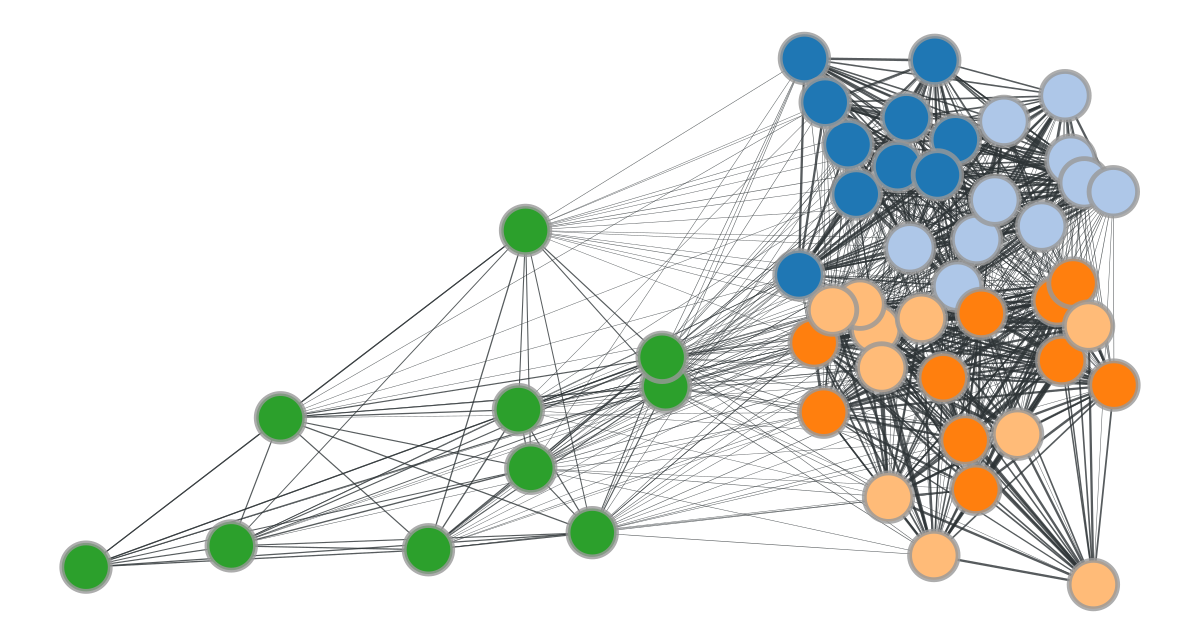

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe0167e8090, at 0x7fe00e44d310>

In [28]:
g_mod_trim.vp.level0 = g_mod_trim.new_vertex_property("int", np.array(state.get_bs()[0]))
graph_draw(g_mod_trim, pos = pos, edge_pen_width = g_mod_trim.ep.weight, 
                                  vertex_fill_color = g_mod_trim.vp.level0)

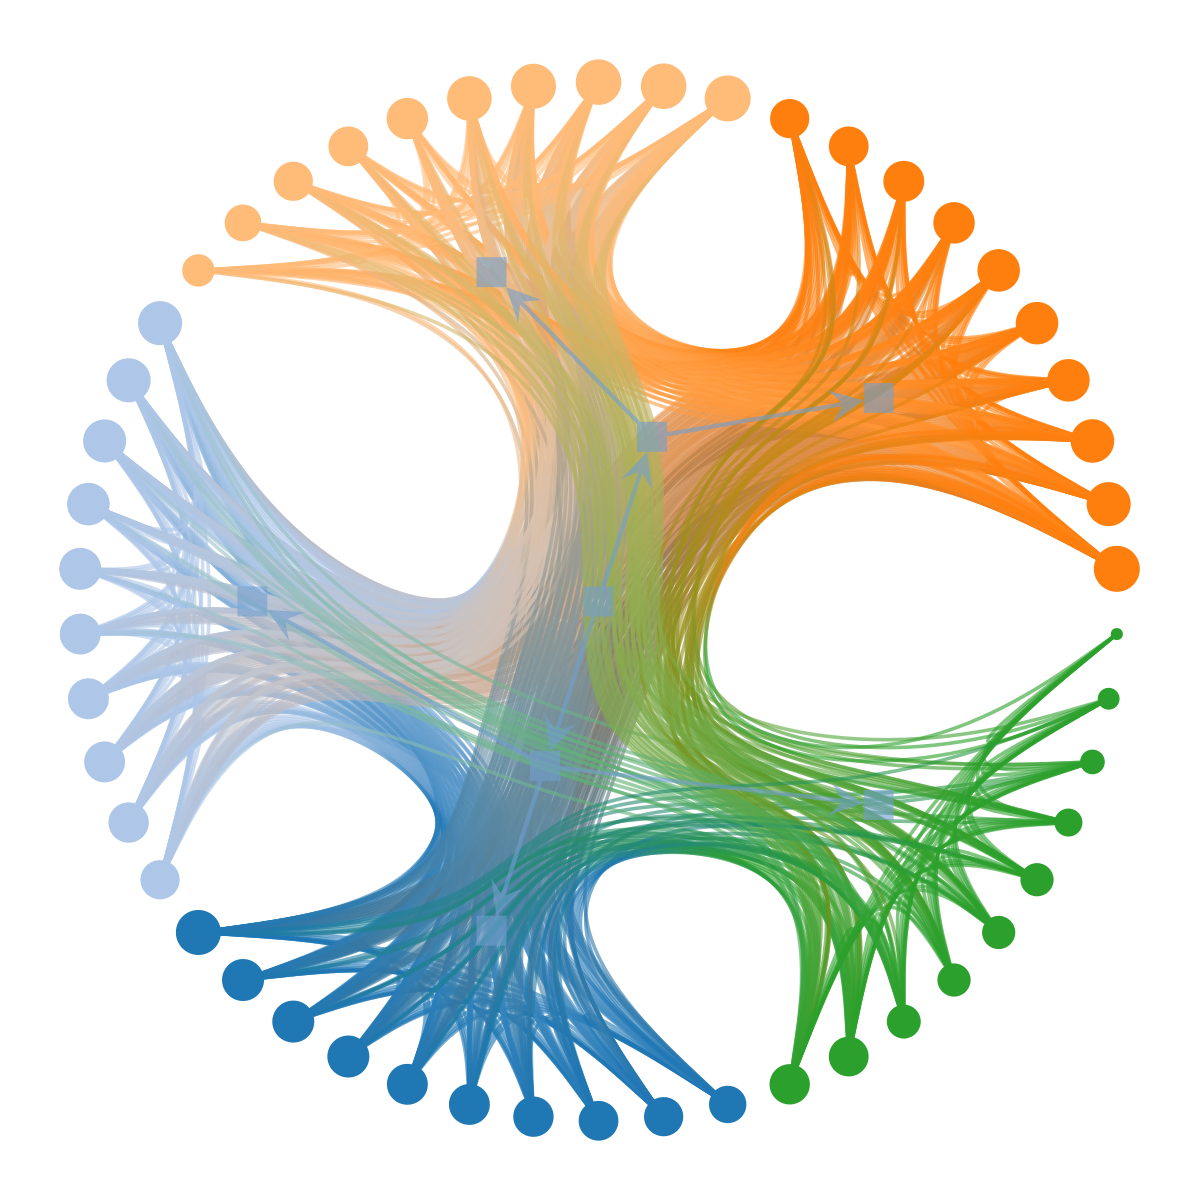

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe0167e8090, at 0x7fe00e447290>,
 <GraphView object, directed, with 58 vertices and 57 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fe00e497490, at 0x7fe00e454f50>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fe00e497490, at 0x7fe00e456b90>, False), at 0x7fe00e497490>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe00e497490, at 0x7fe00e4453d0>)

In [29]:
state.draw()

/tmp/ipykernel_1087234/1748894644.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  simulated_obs = np.random.multivariate_normal(np.zeros(50), non_modular_matrix, 1000)


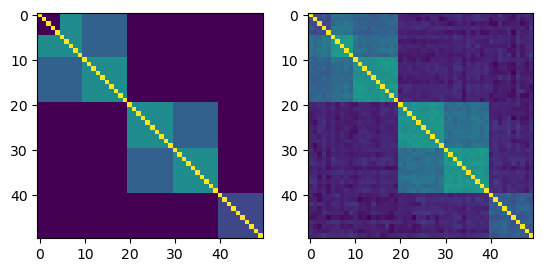

In [42]:
non_modular_matrix = pd.read_csv("non_modular_matrix.csv", index_col=0)

simulated_obs = np.random.multivariate_normal(np.zeros(50), non_modular_matrix, 1000)
import scipy.stats as stats

correlation_matrix = stats.spearmanr(simulated_obs, axis=0).correlation

plt.subplot(1, 2, 1)
plt.imshow(non_modular_matrix, interpolation='nearest')
plt.subplot(1, 2, 2)
plt.imshow(correlation_matrix, interpolation='nearest')
plt.show()

In [43]:
correlation_matrix

array([[1.        , 0.23570133, 0.22574413, ..., 0.09232386, 0.1297506 ,
        0.09629345],
       [0.23570133, 1.        , 0.21985324, ..., 0.05540572, 0.07538448,
        0.08874668],
       [0.22574413, 0.21985324, 1.        , ..., 0.02290976, 0.06370852,
        0.11215596],
       ...,
       [0.09232386, 0.05540572, 0.02290976, ..., 1.        , 0.29439229,
        0.26429203],
       [0.1297506 , 0.07538448, 0.06370852, ..., 0.29439229, 1.        ,
        0.25151568],
       [0.09629345, 0.08874668, 0.11215596, ..., 0.26429203, 0.25151568,
        1.        ]])

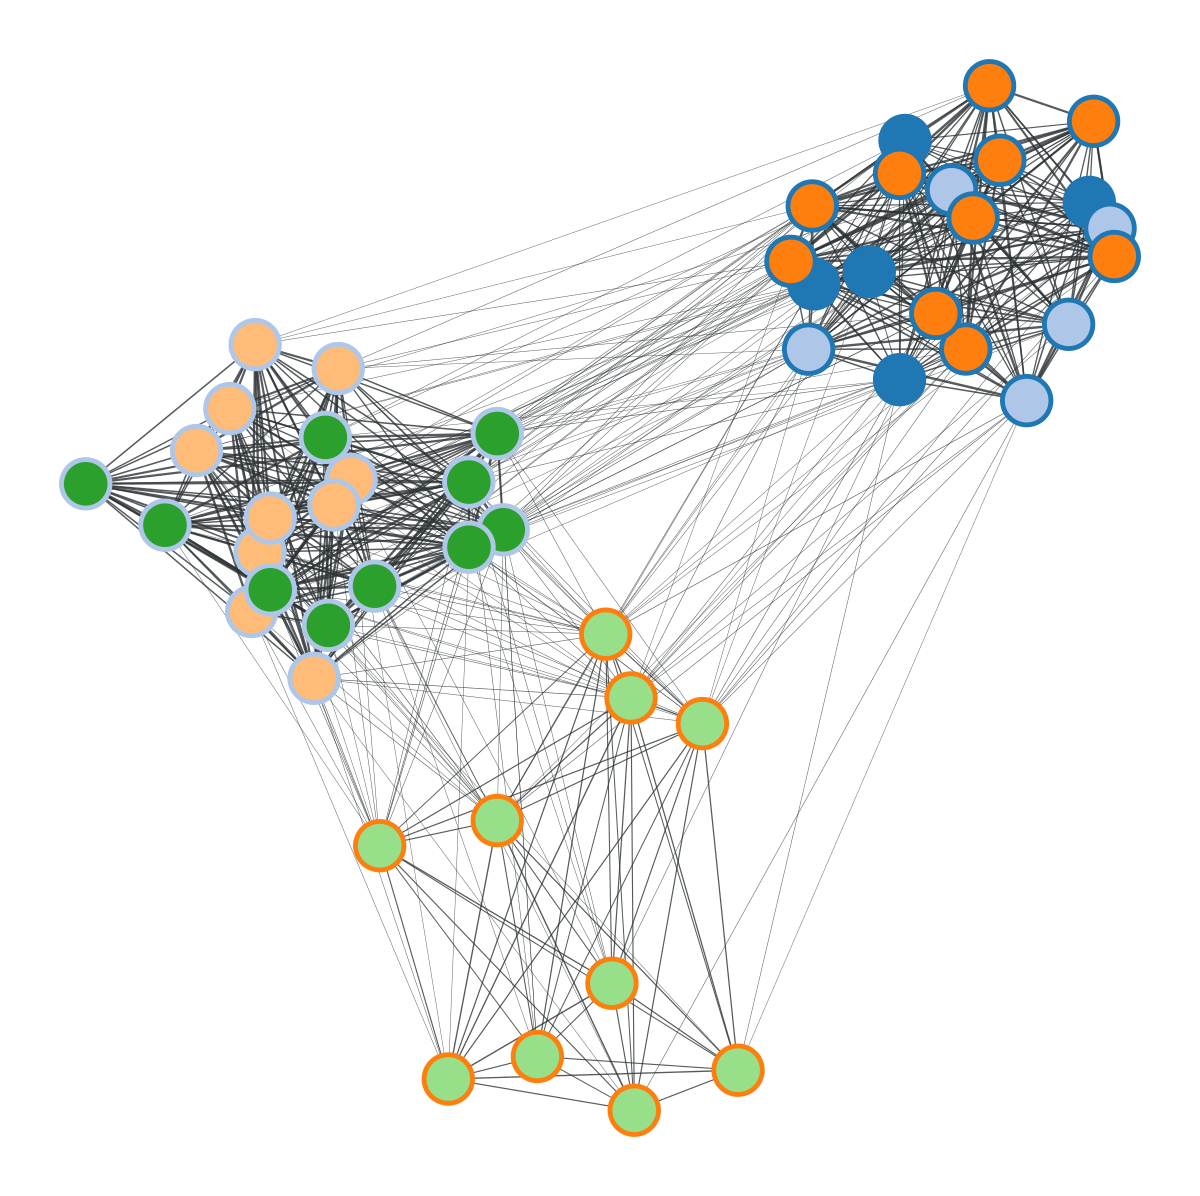

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe005ee4e50, at 0x7fe00e3a0110>

In [51]:
gene_expr = simulated_obs

g_mod = Graph(directed=False)
g_mod.add_vertex(n = 50)

spearman = g_mod.new_ep("double", 0)
pval = g_mod.new_ep("double", 0)

for i in range(50):
    for j in range(i):
        spearman_r = sp.stats.spearmanr(gene_expr[:,i], gene_expr[:,j])
        g_mod.add_edge(i, j)
        e = g_mod.edge(i, j)
        pval[e] = spearman_r[1]
        spearman[e] = spearman_r[0]

g_mod.edge_properties["pvalue"] = pval
g_mod.edge_properties["spearman"] = spearman
g_mod.ep.weight = g_mod.new_edge_property("double", 2*np.arctanh(spearman.a))

community = [0] * 5 + [1] * 5 + [2] * 10 + [3] * 10 + [4] * 10 + [5] * 10
g_mod.vp.community = g_mod.new_vertex_property("int", community)
upper = [6] * 20 + [7] * 20 + [8] * 10
g_mod.vp.upper = g_mod.new_vertex_property("int", upper)

tv = filterByFDR(g_mod, 1e-3, False)
g_mod_trim = Graph(tv, prune = False)
pos = arf_layout(g_mod_trim)
graph_draw(g_mod_trim, pos = pos, edge_pen_width = g_mod_trim.ep.weight, vertex_color=g_mod_trim.vp.upper , vertex_fill_color=g_mod_trim.vp.community)

In [46]:
state = minimize_nested_blockmodel_dl(g_mod_trim, state_args=dict(recs=[g_mod_trim.ep.weight],
                                                              rec_types=["real-normal"], deg_corr=True))
mcmc_equilibrate(state, wait=1000, nbreaks=2, mcmc_args=dict(niter=10))

(197.84938992537172, 7200629, 2152335)

In [47]:
# collect nested partitions
bs = []

def collect_partitions(s):
   global bs
   bs.append(s.get_bs())

# Now we collect the marginals for exactly 100,000 sweeps
mcmc_equilibrate(state, force_niter=1000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, nested=True, converge=True)
pv = pmode.get_marginal(g_mod_trim)

# Get consensus estimate
bs = pmode.get_max_nested()
state = state.copy(bs=bs[0:3])

In [49]:
bs

[array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5], dtype=int32),
 array([0, 0, 0, 1, 1, 1], dtype=int32),
 array([0, 1, 0], dtype=int32),
 array([0, 1], dtype=int32),
 array([0, 1], dtype=int32),
 array([0, 1], dtype=int32),
 array([0, 1], dtype=int32)]

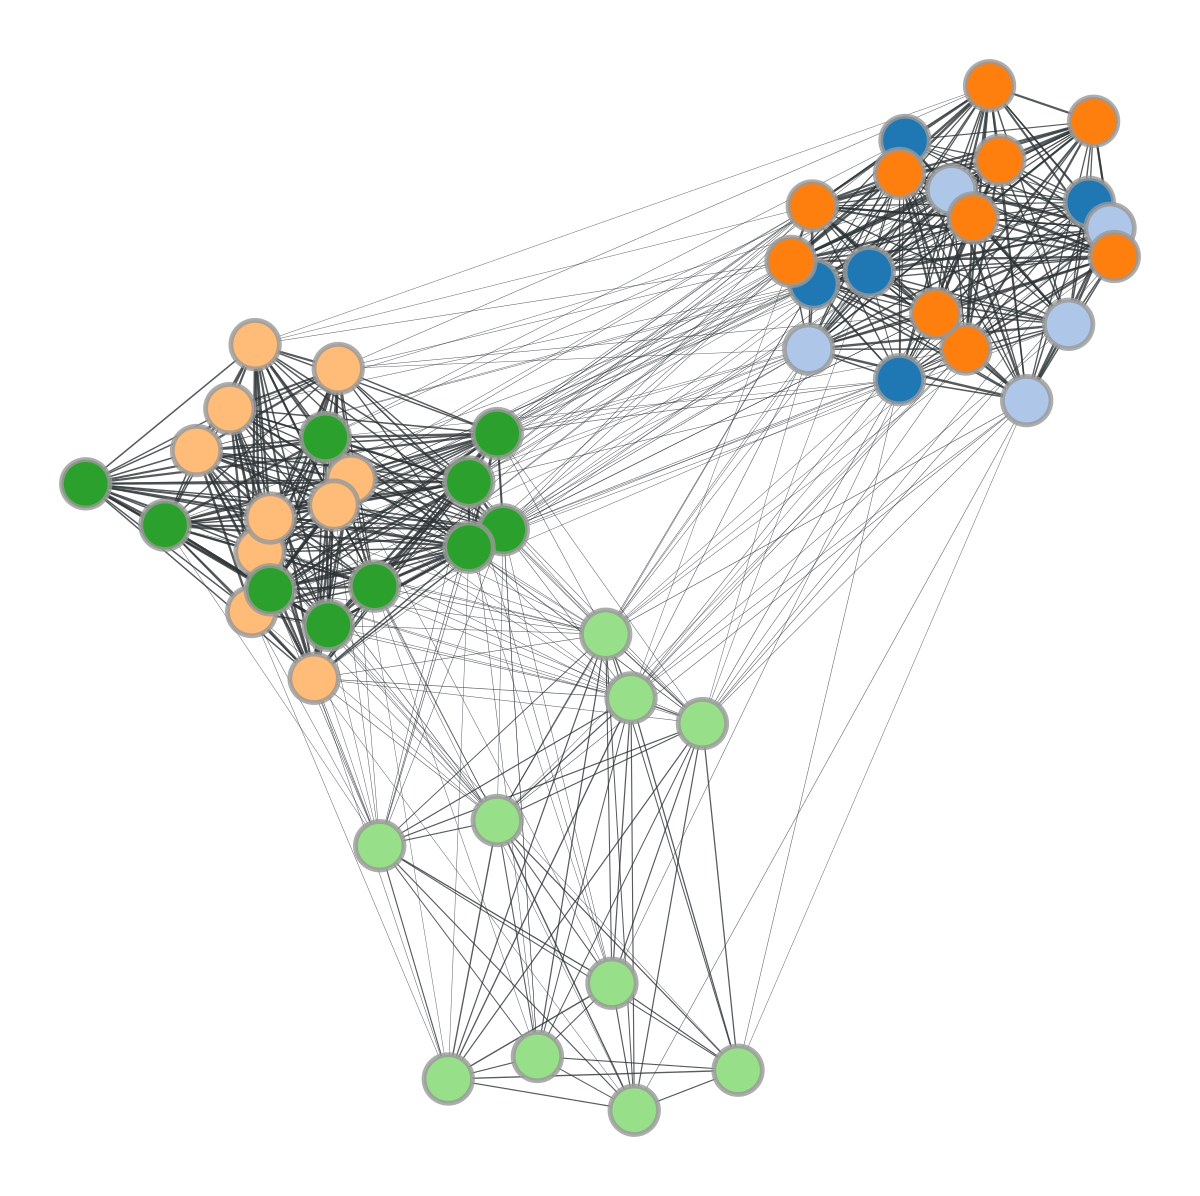

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe005ee4e50, at 0x7fe005dc6010>

In [52]:
g_mod_trim.vp.level0 = g_mod_trim.new_vertex_property("int", np.array(state.get_bs()[0]))
graph_draw(g_mod_trim, pos = pos, edge_pen_width = g_mod_trim.ep.weight, 
                                  vertex_fill_color = g_mod_trim.vp.level0)

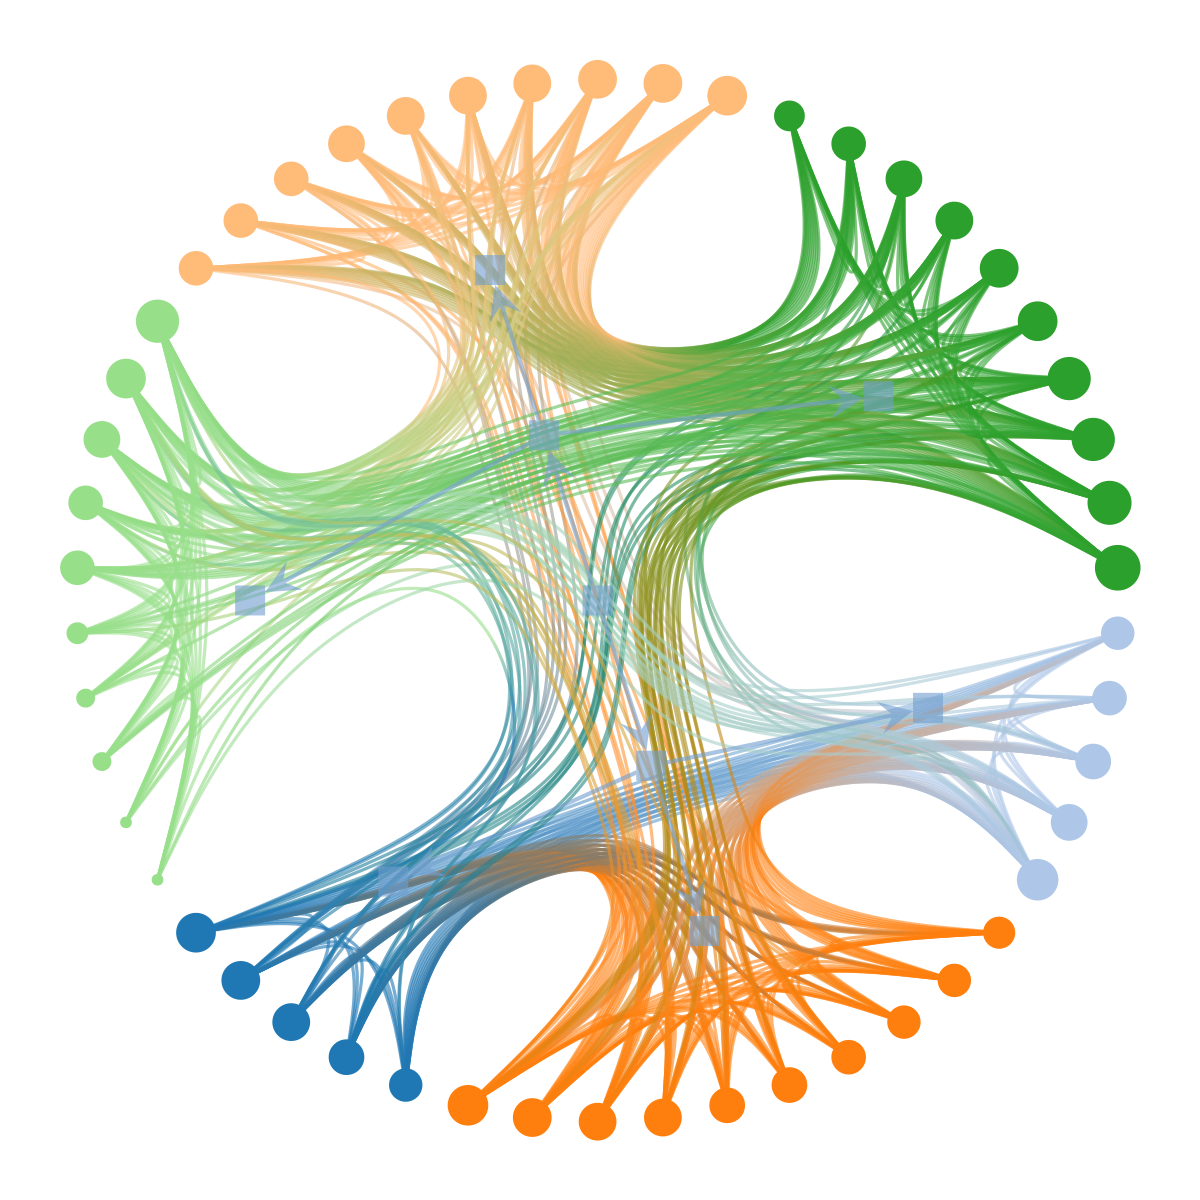

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe00e3c9d90, at 0x7fe005b605d0>,
 <GraphView object, directed, with 59 vertices and 58 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fe005f0f410, at 0x7fe005ef7450>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fe005f0f410, at 0x7fe005f0e210>, False), at 0x7fe005f0f410>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe005f0f410, at 0x7fe005da5dd0>)

In [53]:
state.draw()